# LR and MNIST

In this notebook we will do use multiclass logistic regression to classify MNIST. If you are using your own installation of Jupyter you will need the mnist package which can be installed through anaconda using

conda install -c conda-forge mnist

I must point out that no efforts have been made to optimise this code for either efficiency or elegance, and some of you will no doubt be able to find ways in which it could be improved.

**CAUTION** these notebooks are great, but you must be careful when running the cells out of order, especially if you are using mutable variables

In [0]:
!pip install -q mnist # this line instructs colab to install mnist
import matplotlib.pyplot as plt
import mnist
import numpy as np
from numpy.linalg import inv, det


First, some manipulations. We need to linearise the training data so that we can treat each image as a vector.

In [0]:
# Get the training and test data
train_set = mnist.train_images()
train_labels = mnist.train_labels()
test_set = mnist.test_images()
test_labels = mnist.test_labels()
print(test_set.shape)
print(train_set.shape)

# Reshape the arrays
test_set = np.squeeze(np.array([np.reshape(i,(1,-1)) for i in test_set]))
train_set = np.squeeze(np.array([np.reshape(i,(1,-1)) for i in train_set]))
print(test_set.shape)
print(train_set.shape)

(10000, 28, 28)
(60000, 28, 28)
(10000, 784)
(60000, 784)


## Preprocessing of the data

One problem with the MNIST data is that there are, as we have previously seen, many non-varying pixels around the edge of the images. In LR we do not need to compute the covariance matrix but they risk confounding the classifier so we will remove them.


In [0]:
# Get the sum of each variable into a single vector
S = np.sum(train_set,axis=0).squeeze()

# Define an index of the non-varying and varying pixels
nonvary = S==0
vary = np.array(S!=0).squeeze()

# Choose only the varying pixels in the data
train_set = 1.*train_set[:,vary]
test_set = 1.*test_set[:,vary]

## Training the model

Training in scikit-learn is easy. The `lbgfs` solver is chosen for efficiency - it is faster than IRLS. Here is the model interface:

`class sklearn.linear_model.LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver=’warn’, max_iter=100, multi_class=’warn’, verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)`

Note that the default is to have the model regularised with an $L_2$ penalty and inverse regularisation parameter $C=1.0$.

In [0]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
model = LR.fit(train_set, train_labels)

## Testing

Now run the predictions on both training and test data.

In [0]:
predict_train = model.predict(train_set)
predict_test = model.predict(test_set)

## Evaluating

We compute some evaluation metrics on the outcome (ie the confusion matrix)

In [0]:
def evaluate(predicted_labels, true_labels):
    # Create an empty confusion matrix
    confusion_matrix = np.zeros([10,10])
    
    # For each item in the test set, add it's prediction into the confusion matrix
    for i, l in enumerate(true_labels):
        confusion_matrix[l, predicted_labels[i]] += 1
    
    # Normalise each row
    for i, row in enumerate(confusion_matrix):
        confusion_matrix[i] /= sum(confusion_matrix[i])
        
    # Print the matrix (formatted for copying into a latex document)
    for i,c in enumerate(confusion_matrix):
        print(str(i) + ' & ' + ' & '.join(['{:3.2f}'.format(i) for i in c]) + '\\\\ \hline')
    
    # Plot the matrix
    plt.imshow(confusion_matrix,cmap='gray')
    plt.tight_layout()
    plt.grid('off')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    
    # Compute and print the overall accuracy
    print(sum(confusion_matrix.diagonal())/sum(sum(confusion_matrix)))

0 & 0.97 & 0.00 & 0.00 & 0.00 & 0.00 & 0.01 & 0.01 & 0.00 & 0.01 & 0.00\\ \hline
1 & 0.00 & 0.98 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.01 & 0.00\\ \hline
2 & 0.00 & 0.01 & 0.91 & 0.01 & 0.01 & 0.00 & 0.01 & 0.01 & 0.02 & 0.00\\ \hline
3 & 0.00 & 0.00 & 0.02 & 0.91 & 0.00 & 0.03 & 0.00 & 0.01 & 0.02 & 0.01\\ \hline
4 & 0.00 & 0.00 & 0.00 & 0.00 & 0.94 & 0.00 & 0.01 & 0.00 & 0.01 & 0.03\\ \hline
5 & 0.01 & 0.00 & 0.01 & 0.03 & 0.01 & 0.88 & 0.02 & 0.00 & 0.03 & 0.01\\ \hline
6 & 0.01 & 0.00 & 0.01 & 0.00 & 0.01 & 0.01 & 0.97 & 0.00 & 0.00 & 0.00\\ \hline
7 & 0.00 & 0.00 & 0.01 & 0.00 & 0.01 & 0.00 & 0.00 & 0.94 & 0.00 & 0.03\\ \hline
8 & 0.00 & 0.02 & 0.01 & 0.02 & 0.00 & 0.02 & 0.01 & 0.00 & 0.90 & 0.01\\ \hline
9 & 0.00 & 0.00 & 0.00 & 0.01 & 0.02 & 0.01 & 0.00 & 0.02 & 0.01 & 0.92\\ \hline
0.9329392320294236


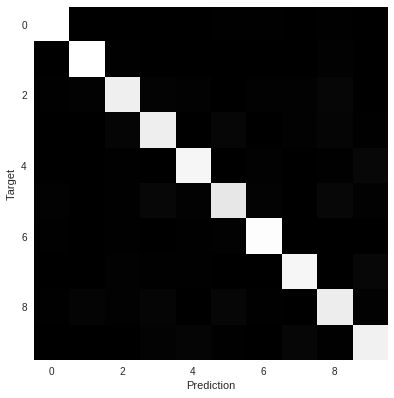

In [0]:
evaluate(predict_train, train_labels)

0 & 0.98 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00\\ \hline
1 & 0.00 & 0.98 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.01 & 0.00\\ \hline
2 & 0.00 & 0.01 & 0.90 & 0.01 & 0.01 & 0.00 & 0.01 & 0.01 & 0.04 & 0.00\\ \hline
3 & 0.00 & 0.00 & 0.02 & 0.91 & 0.00 & 0.03 & 0.00 & 0.01 & 0.02 & 0.01\\ \hline
4 & 0.00 & 0.00 & 0.01 & 0.00 & 0.93 & 0.00 & 0.01 & 0.01 & 0.01 & 0.03\\ \hline
5 & 0.01 & 0.00 & 0.00 & 0.04 & 0.01 & 0.87 & 0.01 & 0.01 & 0.04 & 0.01\\ \hline
6 & 0.01 & 0.00 & 0.01 & 0.00 & 0.01 & 0.02 & 0.95 & 0.00 & 0.00 & 0.00\\ \hline
7 & 0.00 & 0.01 & 0.02 & 0.00 & 0.01 & 0.00 & 0.00 & 0.93 & 0.00 & 0.03\\ \hline
8 & 0.01 & 0.01 & 0.01 & 0.02 & 0.01 & 0.03 & 0.01 & 0.01 & 0.89 & 0.01\\ \hline
9 & 0.01 & 0.01 & 0.00 & 0.01 & 0.02 & 0.01 & 0.00 & 0.02 & 0.01 & 0.91\\ \hline
0.9244207693413399


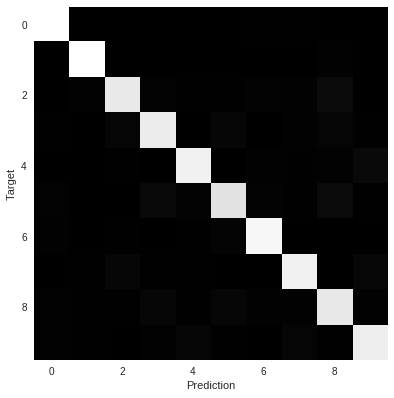

In [0]:
evaluate(predict_test, test_labels)